In [171]:
### Libraries ###
import importlib
import torch
import torch.nn as nn
from torchsummary import summary



### Local Files ###
import data
importlib.reload(data)
import encoder
importlib.reload(encoder)
import decoder
importlib.reload(decoder)
import training_VAE
importlib.reload(training_VAE)

<module 'training_VAE' from 'c:\\Users\\kobil\\Documents\\CSC2516\\Final_proj\\DL-AutoEncoder\\training_VAE.py'>

## **Parameters**

In [172]:
cuda = torch.cuda.is_available()
DEVICE = torch.device("cuda" if cuda else "cpu")

#Experiment parameters
batch_size = 64
pretrained = True
freeze_gradient = True
latent_dim = 128


## **Load Data**

In [173]:
# from data import get_datasets,dataset_to_dataloader
train_ds, val_ds, test_ds = data.get_datasets()
train_dl = data.dataset_to_dataloader(train_ds, batch_size = batch_size)
val_dl = data.dataset_to_dataloader(val_ds, batch_size = batch_size)
test_dl = data.dataset_to_dataloader(test_ds, batch_size = batch_size)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


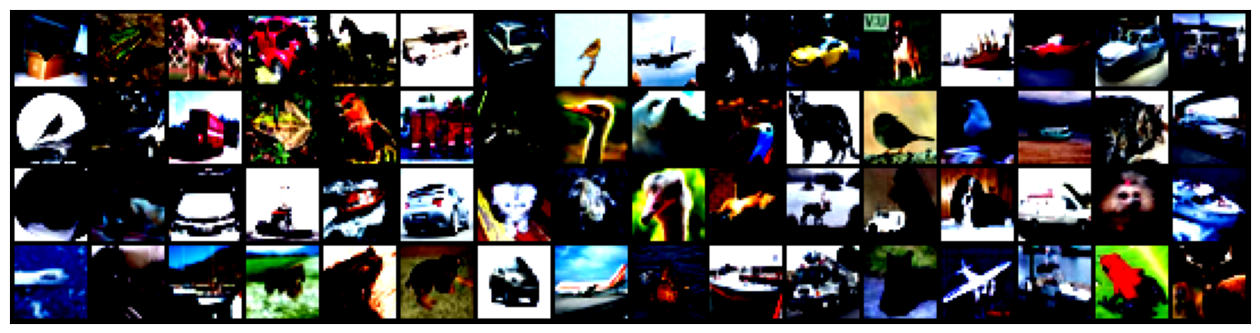

In [174]:
data.test_dataloader(train_dl)

## **VAE**

**Encoder**

In [175]:
class VAE_encoder(nn.Module):
    def __init__(self,CNN, latent_dim = latent_dim):
        super().__init__()
        
        self.conv_layers = CNN

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.conv_layers.fc = nn.Sequential(self.LeakyReLU ,
                                            nn.Linear(512, latent_dim))

        self.fc_mean = nn.Sequential(self.LeakyReLU,
                                     nn.Linear(latent_dim, latent_dim))
        self.fc_var = nn.Sequential(self.LeakyReLU,
                                     nn.Linear(latent_dim, latent_dim))

        self.norm = torch.distributions.Normal(0,1)
        self.norm.loc = self.norm.loc.cuda() # hack to get sampling on the GPU
        self.norm.scale = self.norm.scale.cuda()
        self.kl = 0


    def forward (self, x):
       x = self.conv_layers(x)
       mu = self.fc_mean(x)
       sigma = torch.exp(self.fc_var(x))
       z = mu + sigma*self.norm.sample(mu.shape)
       self.k1 = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
       return z

In [176]:
resnet = encoder.resnet18(pretrained = pretrained)
if(freeze_gradient):
    for param in resnet_enc.parameters():
            param.requires_grad = False


resnet_encoder = VAE_encoder(resnet).to(DEVICE)

In [177]:
summary(resnet_encoder, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
       BasicBlock-11           [-1, 64, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

**Decoder**

In [178]:
class VAE_decoder(nn.Module):
    def __init__(self,decoder_model, latent_dim = latent_dim):
        super().__init__()
        
        self.decoder = decoder_model

    def forward (self, x):
       x = self.decoder(x)
       x_hat = torch.sigmoid(x)
       return x_hat

In [179]:
resnet_dec = decoder.ResNet18Dec(z_dim = latent_dim)
decoder = VAE_decoder(resnet_dec)

**VAE Wrapper**

In [180]:
class VAE(nn.Module):
    def __init__(self,encoder_model, decoder_model):
        super().__init__()
        self.encoder = encoder_model
        self.decoder = decoder_model
    

    def forward(self, x):
        z =self.encoder(x)
        return self.decoder(z)

In [181]:
model = VAE(resnet_encoder, resnet_dec).to(DEVICE)

## **Training**

In [182]:
optimizer = torch.optim.Adam(model.parameters())
model, history = training_VAE.train(
    model,
    optimizer,
    train_dl,
    val_dl,
    save_file_name='VAE.pt',
    max_epochs_stop=5,
    n_epochs=20,
    print_every=1)

print(history)
history.to_csv('VAE_History.csv')

Starting Training from Scratch.

Epoch: 0	100.00% complete. 103.41 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 148079.2135 	Validation Loss: 109056.6033
Epoch: 1	100.00% complete. 103.96 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 102972.7202 	Validation Loss: 99513.6492


In [ ]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        with torch.no_grad():
          for t, m, s in zip(tensor, self.mean, self.std):
              t.mul_(s).add_(m)
              # The normalize code -> t.sub_(m).div_(s)
          return tensor

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
unorm = UnNormalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616))

def peek_results(dataloader, model):
  for img,lb in dataloader:
    fig, ax = plt.subplots(figsize=(16,8))
    fig1, ax1 = plt.subplots(figsize=(16,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax1.set_xticks([]); ax1.set_yticks([])
    img_output = model(img.cuda())
    img_output = img_output.cpu()
    print(img_output.size())
    ax.imshow(make_grid(unorm(img_output), nrow=16).permute(1,2,0))
    ax1.imshow(make_grid(img, nrow=16).permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 32, 32])


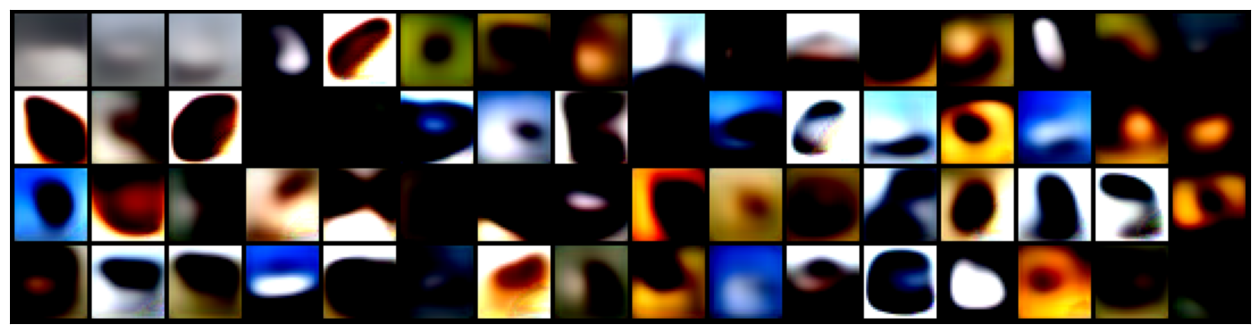

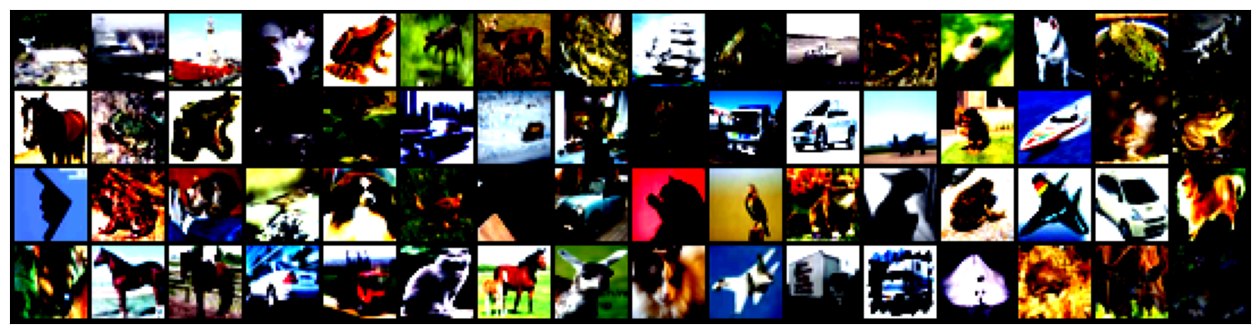

In [ ]:
peek_results(test_dl, model)